In [8]:
import numpy as np
import pandas as pd
import re

### Data Preprocessing

In [ ]:
path = "sp500.csv
df = pd.read_csv(path)

print(df.head())


/var/folders/ls/t8r2njx51vs74mk0rncxwb7m0000gn/T/ipykernel_5918/3789968418.py:2: DtypeWarning: Columns (6,9,19,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


   PERMNO        date NAMEENDT  SHRCD  EXCHCD   SICCD    NCUSIP TICKER  \
0   10104  2001-01-02      NaN   11.0     3.0  7370.0  68389X10   ORCL   
1   10104  2001-01-03      NaN   11.0     3.0  7370.0  68389X10   ORCL   
2   10104  2001-01-04      NaN   11.0     3.0  7370.0  68389X10   ORCL   
3   10104  2001-01-05      NaN   11.0     3.0  7370.0  68389X10   ORCL   
4   10104  2001-01-08      NaN   11.0     3.0  7370.0  68389X10   ORCL   

        COMNAM SHRCLS  ... CFACPR  CFACSHR  OPENPRC   NUMTRD      RETX  \
0  ORACLE CORP    NaN  ...    1.0      1.0  29.5625  49047.0 -0.092473   
1  ORACLE CORP    NaN  ...    1.0      1.0  25.2500  74159.0   0.21327   
2  ORACLE CORP    NaN  ...    1.0      1.0  31.5625  56474.0  0.017578   
3  ORACLE CORP    NaN  ...    1.0      1.0  32.5000  46607.0 -0.074856   
4  ORACLE CORP    NaN  ...    1.0      1.0  30.0625  44132.0 -0.006224   

     vwretd    vwretx    ewretd    ewretx    sprtrn  
0 -0.034230 -0.034236 -0.001135 -0.001155 -0.028032  
1 

In [24]:
columns = ["RETX", "date","TICKER"]
df = df[columns]

In [25]:
df.head()

,RETX,date,TICKER
0,-0.092473,2001-01-02,ORCL
1,0.21327,2001-01-03,ORCL
2,0.017578,2001-01-04,ORCL
3,-0.074856,2001-01-05,ORCL
4,-0.006224,2001-01-08,ORCL


In [26]:
def convert_to_number(x):
    try:
        return float(x)
    except:
        return None

df['ret_parsed'] = df['RETX'].apply(convert_to_number)

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.drop(columns=["RETX"], inplace=True)

In [31]:
df.head()

,TICKER,ret_parsed
date,,
2001-01-02,ORCL,-0.092473
2001-01-03,ORCL,0.213270
2001-01-04,ORCL,0.017578
2001-01-05,ORCL,-0.074856
2001-01-08,ORCL,-0.006224


In [36]:
df = df.pivot_table(index=df.index, columns="TICKER", values="ret_parsed", aggfunc="first")

In [37]:
df.fillna(0, inplace=True)

### PCA factors regression

Here, we use the fact that via PCA decomposition, we have

R = PSQ
P is N*K matrix. Assuming we "learn" this,
we could input the new Q each day: K\*1 (the factors that day). Then we make a prediction on N\*1 market return


In [ ]:
ratio = 0.8
train_size = int(len(df) * ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

train_data.head()

In [44]:
from sklearn.decomposition import PCA

K = 5  # Number of principal components/factors, you can set this as needed

# Perform PCA decomposition on the training data
pca = PCA(n_components=K)
P = pca.fit(train_data.values)      # Shape: (N, K), N = number of timestamps/rows in train_data, but you want N = number of assets
print((P.components_.shape))


(5, 667)


In [75]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge


returns = df
# assume `returns` is a (T, N) DataFrame with dates as index
window = 252
n_factors = 5
ridge_alpha = 1e-2  # small regularization for stability

dates = returns.index
N = returns.shape[1]
preds = np.full_like(returns.values, np.nan)

# preallocate for betas and alphas
betas = np.zeros((len(returns)-window-1, N, n_factors))
alphas = np.zeros((len(returns)-window-1, N))

for t in range(window, len(returns)-1):
    # 1️⃣ Rolling PCA on past window
    X_win = returns.iloc[t-window:t].values
    pca = PCA(n_components=n_factors)
    F_win = pca.fit_transform(X_win)        # (window, K)
    F_t = F_win[-1]                         # factors at time t
    loadings = pca.components_.T            # (N, K)
    
    # 2️⃣ Prepare data for ridge regression
    # regress next-day returns (N×1) on current factors (K×1)
    r_next = returns.iloc[t+1].values       # (N,)
    F_design = F_t.reshape(1, -1)
    
    # use vectorized ridge: each stock separately, but stacked
    # fit over recent few lags for more stability (optional)
    F_hist = F_win[-100:]                     # last 5 days' factors
    R_hist = returns.iloc[t-99:t+1].values   # next-day returns of same length if aligned
    
    # if you want per-stock regression over F_hist
    X = np.hstack([np.ones((F_hist.shape[0],1)), F_hist])  # add intercept
    XtX = X.T @ X + ridge_alpha * np.eye(X.shape[1])
    XtY = X.T @ R_hist                                    # (K+1, N)
    coef = np.linalg.solve(XtX, XtY)                      # (K+1, N)
    alpha_t = coef[0]                                     # (N,)
    beta_t = coef[1:].T                                   # (N,K)


    # 3️⃣ Predict next-day returns using F_t
    preds[t+1, :] = alpha_t + beta_t @ F_t
    
    betas[t-window, :, :] = beta_t
    alphas[t-window, :] = alpha_t

# convert predictions to DataFrame
pred_df = pd.DataFrame(preds, index=returns.index, columns=returns.columns)


In [60]:
pred_df.tail()

TICKER,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,0.0,-0.003787,0.0,-0.000504,-0.005395,0.001903,0.0,-0.001234,0.0,0.0,...,0.000740,-0.002120,-0.003665,-0.001158,-0.002656,0.003699,0.004130,0.0,0.0,-0.007212
2024-12-26,0.0,0.001097,0.0,0.010408,-0.000498,0.002941,0.0,-0.002531,0.0,0.0,...,-0.001913,-0.012922,0.001583,0.001081,0.003130,0.002776,0.003475,0.0,0.0,0.000472
2024-12-27,0.0,-0.000743,0.0,0.001976,0.000873,0.002960,0.0,-0.000575,0.0,0.0,...,-0.002293,-0.012098,-0.001082,0.001171,-0.000913,0.002653,0.001748,0.0,0.0,-0.001397
2024-12-30,0.0,-0.000907,0.0,0.002738,-0.005830,0.000856,0.0,0.001701,0.0,0.0,...,-0.001409,0.008897,-0.001961,-0.000296,-0.000670,0.000757,0.001418,0.0,0.0,-0.001662
2024-12-31,0.0,0.000328,0.0,0.014918,-0.005179,0.000703,0.0,-0.002957,0.0,0.0,...,-0.001094,0.011514,-0.000762,-0.001888,0.000098,0.002107,0.002993,0.0,0.0,-0.001851


In [62]:
returns.tail()

TICKER,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,0.0,0.011144,0.0,0.005797,-0.000457,0.011478,0.0,0.009025,0.0,0.0,...,0.000941,-0.002639,0.005446,0.008516,0.004494,0.012262,0.010850,0.0,0.0,0.002557
2024-12-26,0.0,-0.001984,0.0,0.000000,0.011663,0.003176,0.0,-0.004444,0.0,0.0,...,0.000846,0.013757,0.002708,0.007407,-0.000466,0.003566,0.006913,0.0,0.0,0.004979
2024-12-27,0.0,-0.002135,0.0,0.000000,-0.004069,-0.013242,0.0,-0.006641,0.0,0.0,...,-0.000094,-0.011482,-0.007935,-0.005662,-0.003543,-0.019604,-0.012105,0.0,0.0,-0.005558
2024-12-30,0.0,-0.008263,0.0,0.015562,0.045166,-0.013263,0.0,-0.010168,0.0,0.0,...,-0.006762,-0.015312,-0.010636,-0.012645,-0.013755,-0.013417,-0.006584,0.0,0.0,-0.014338
2024-12-31,0.0,-0.000595,0.0,-0.010783,0.026927,-0.007058,0.0,0.008513,0.0,0.0,...,0.017114,0.017694,-0.002236,0.004793,0.002182,0.006174,-0.001289,0.0,0.0,0.004253


### neural network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

# Assume `returns` is a (T, N) pandas DataFrame, indexed by date
X_all = torch.tensor(returns.shift(1).iloc[1:].values, dtype=torch.float32)  # r_t
y_all = torch.tensor(returns.iloc[1:].values, dtype=torch.float32)           # r_{t+1}
T, N = X_all.shape

# --------------- Train/Test Split (preserve order) ---------------
split_idx = int(T * 0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

# --------------- Normalize using training set only ---------------
mean = X_train.mean(0, keepdim=True)
std = X_train.std(0, keepdim=True) + 1e-6
X_train = (X_train - mean) / std
y_train = (y_train - mean) / std
X_test = (X_test - mean) / std
y_test = (y_test - mean) / std

# --------------- Neural Network Definition ---------------
class ReturnPredictor(nn.Module):
    def __init__(self, N, hidden_dim=256, depth=3, dropout=0.1):
        super().__init__()
        layers = []
        in_dim = N
        for _ in range(depth):
            layers += [
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden_dim)
            ]
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, N))  # output dimension N
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = ReturnPredictor(N, hidden_dim=128, depth=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --------------- Training Loop ---------------
n_epochs = 100
batch_size = 32
T_train = len(X_train)

for epoch in range(n_epochs):
    total_loss = 0
    for i in range(0, T_train, batch_size):
        Xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(Xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(Xb)
    if (epoch+1) % 10 == 0:
        avg_loss = total_loss / T_train
        print(f"Epoch {epoch+1:03d} | Train Loss {avg_loss:.6f}")

# --------------- Evaluation ---------------
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum().item()
    ss_tot = ((y_true)**2).sum().item()
    return 1 - ss_res / ss_tot

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print(f"\nTrain R² = {r2_train:.4f}")
print(f" Test R² = {r2_test:.4f}")

# --------------- Convert predictions back to DataFrame ---------------
y_hat_test = (y_pred_test * std + mean).numpy()
pred_df = pd.DataFrame(
    y_hat_test,
    index=returns.index[1:][split_idx:],
    columns=returns.columns
)



ModuleNotFoundError: No module named 'torch'

In [57]:
returns.to_csv("returns.csv")

### evaluation

In [64]:
import numpy as np
import pandas as pd

# Align the two DataFrames just in case
pred_df, ret_df = pred_df.align(returns, join='inner', axis=0)

# Flatten NaNs (drop dates without predictions)
mask = ~np.isnan(pred_df.values) & ~np.isnan(ret_df.values)
y_true = ret_df.values[mask]
y_pred = pred_df.values[mask]

# ---------- 1. Overall R^2 ----------
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true) ** 2)
r2_overall = 1 - ss_res / ss_tot
print(f"Overall R^2: {r2_overall:.6f}")

# ---------- 2. Per-stock R^2 ----------
# compute column-wise R^2 for each stock
r2_per_stock = 1 - ((ret_df - pred_df)**2).sum() / ((ret_df)**2).sum()
r2_per_stock = r2_per_stock.to_frame("R2")
print(r2_per_stock.sort_values("R2", ascending=True).head())


Overall R^2: -0.098890
              R2
TICKER          
REI    -0.386041
SPGI   -0.263404
APTV   -0.247285
DXC    -0.239593
EVRG   -0.227019


In [65]:
((ret_df - pred_df)**2).sum()

TICKER
0       0.000000
A       2.821736
AA      2.839282
AAL     2.851909
AAP     2.978847
          ...   
ZBRA    3.025946
ZION    5.180733
ZMH     1.110105
ZMX     0.272278
ZTS     0.859840
Length: 667, dtype: float64

In [67]:
(ret_df**2).sum()

TICKER
0       0.000000
A       3.042630
AA      2.841680
AAL     2.737365
AAP     2.773151
          ...   
ZBRA    3.097412
ZION    4.840747
ZMH     1.080456
ZMX     0.337554
ZTS     0.768496
Length: 667, dtype: float64

In [68]:
((ret_df - pred_df)**2).sum() / ((ret_df)**2).sum()

TICKER
0            NaN
A       0.927400
AA      0.999156
AAL     1.041845
AAP     1.074174
          ...   
ZBRA    0.976927
ZION    1.070234
ZMH     1.027442
ZMX     0.806619
ZTS     1.118861
Length: 667, dtype: float64

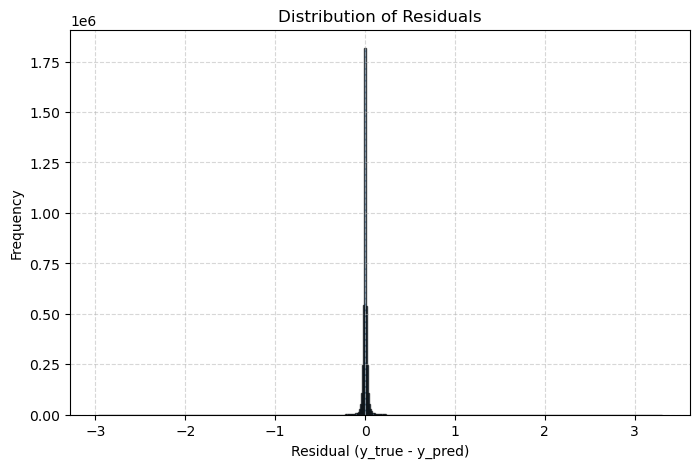

In [54]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=500, alpha=0.7, color='steelblue', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
